In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten
from keras import Model
import keras
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

In [3]:

def build_embedding_generator(k_layers_to_tune=10):

    base_model = tf.keras.applications.ResNet50V2(weights="imagenet", 
                                                      input_shape=(100, 100, 3),
                                                      include_top = False)

    for l in base_model.layers[:-k_layers_to_tune]:
        l.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="sigmoid")(x)
    #x = tf.nn.l2_normalize(x, axis=1)
    
    embedding_model = Model(base_model.input, x, name="Embedding")

    return embedding_model


In [4]:
embedding_model = build_embedding_generator(5)



In [5]:
embedding_model.load_weights("embeddings_resnet50_bigmargin.h5")

In [176]:
embedding_model.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 52, 52, 64)           0         ['conv1_conv[0][0]']          
                                                                                          

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 25, 25, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 25, 25, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 25, 25, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 13, 13, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 15, 15, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 13, 13, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 13, 13, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 7, 7, 512)            66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 7, 7, 512)            0         ['max_pooling2d_25[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 7, 7, 512)            2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 7, 7, 256)            1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 7, 7, 256)            0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 9, 9, 256)            0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 7, 7, 256)            0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 7, 7, 1024)           263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 7, 7, 1024)           0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 7, 7, 1024)           4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 4, 4, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 4, 4, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

 dense_25 (Dense)            (None, 256)                  131328    ['dropout_8[0][0]']           
                                                                                                  
 batch_normalization_17 (Ba  (None, 256)                  1024      ['dense_25[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dense_26 (Dense)            (None, 128)                  32896     ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
Total params: 24781184 (94.53 MB)
Trainable params: 2269568 (8.66 MB)
Non-trainable params: 22511616 (85.88 MB)
________________________________________________________________________________________________

### Custom layers & Model

In [6]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):

        
        anchor_pos_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        anchor_neg_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

        return (anchor_pos_distance, anchor_neg_distance)


def build_siamesenetwork(embedding_model):

    anchor_input = keras.layers.Input(name="anchor", shape=(100, 100, 3))
    pos_input = keras.layers.Input(name="positive", shape=(100, 100, 3))
    neg_input = keras.layers.Input(name="negative", shape=(100, 100, 3))

    distances = DistanceLayer()(
        embedding_model(anchor_input),
        embedding_model(pos_input),
        embedding_model(neg_input)
    )

    siamese_network = Model(
            inputs=[anchor_input, pos_input, neg_input],
            outputs=distances
    )

    return siamese_network



In [7]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    

    def train_step(self, data):

        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)

        return {"loss" : self.loss_tracker.result()}

    def _compute_loss(self, data):

        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        #loss = an_distance - ap_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss" : self.loss_tracker.result()}

    @property
    def metrics(self):

        return [self.loss_tracker]


In [180]:
siam_net = build_siamesenetwork(embedding_model)

In [181]:
siam_model = SiameseModel(siam_net, margin=20)

## UTILS


In [8]:
import pandas as pd
import numpy as np

In [9]:
PATH_TO_IMGS = "../images/"

triplets_df = pd.read_csv("../triplets.csv")




def parse_csv_line(line):
    columns = ['anchor', 'id1', 'pos', 'id2', 'neg', 'id3']
    
    # Decode the CSV line
    record_defaults = [''] * 6  # All fields are strings
    parsed_line = tf.io.decode_csv(line, record_defaults)
    parsed_line = dict(zip(columns, parsed_line))
    return parsed_line


def load_and_preprocess_image(path):
    
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])
    image = image / 255.0
    return image



def create_triplet_dataset(csv_file_path, batch_size=32):
    dataset = tf.data.TextLineDataset(csv_file_path)
    # Skip the header line
    dataset = dataset.skip(1)
    
    # Parse each line
    dataset = dataset.map(lambda line: parse_csv_line(line))
    # Load and preprocess the images
    def load_images(parsed_line):

        base_path = tf.constant(PATH_TO_IMGS)
        
        anchor_path = tf.strings.join([base_path, parsed_line['anchor']], separator='')
        pos_path = tf.strings.join([base_path, parsed_line['pos']], separator='')
        neg_path = tf.strings.join([base_path, parsed_line['neg']], separator='')

        
        anchor = load_and_preprocess_image(anchor_path)
        pos = load_and_preprocess_image(pos_path)
        neg = load_and_preprocess_image(neg_path)
        return anchor, pos, neg

    
    dataset = dataset.map(load_images)
    dataset = dataset.batch(batch_size)
    return dataset


In [13]:
dataset = create_triplet_dataset("../triplets.csv", batch_size=1000)


batch = next(iter(dataset.take(1)))

2024-03-07 22:06:08.297990: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 120000000 exceeds 10% of free system memory.
2024-03-07 22:06:08.298195: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 120000000 exceeds 10% of free system memory.
2024-03-07 22:06:08.298239: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 120000000 exceeds 10% of free system memory.
2024-03-07 22:06:09.209362: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 120000000 exceeds 10% of free system memory.
2024-03-07 22:06:09.243046: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 120000000 exceeds 10% of free system memory.


In [185]:
class SaveEmbeddingModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path, model_to_save):
        super(SaveEmbeddingModelCallback, self).__init__()
        self.save_path = save_path  # Directory where you want to save your model
        self.model_to_save = model_to_save  # The model instance you want to save

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of an epoch.
        
        Arguments:
            epoch: integer, index of epoch.
            logs: dict, metric results for this training epoch, and for the
                  validation epoch if validation is performed.
        """
        # Define file path; you could also include epoch in the filename if you wish
        file_path = os.path.join(self.save_path, f'embedding_model_epoch_{epoch+1}.h5')
        
        # Save the model
        self.model_to_save.save(file_path)
        print(f'\nModel saved to {file_path} at the end of epoch {epoch+1}')





save_embedding = SaveEmbeddingModelCallback(save_path="emb_checkpoints/", model_to_save=embedding_model)


# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,  # Set to False to save the entire model     # Set to False to save the model after every epoch regardless of performance
#     verbose=1                 # Logs a message whenever a model is save9d
# )

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/", update_freq="batch")



In [ ]:
siam_model.compile(optimizer=keras.optimizers.Adam(0.00001), 
                   )

try:
    siam_model.fit(dataset, 
                   epochs=30,
                   callbacks=[save_embedding, tensorboard]
                   )

    
except KeyboardInterrupt:
    print("Trainig is interrupted")
embedding_model.save_weights("embeddings_resnet50_bigmargin.h5")

Epoch 1/30
    681/Unknown - 1736s 3s/step - loss: 13.9388WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.

Model saved to emb_checkpoints/embedding_model_epoch_1.h5 at the end of epoch 1
681/681 [==============================] - 1737s 3s/step - loss: 13.9388
Epoch 2/30
681/681 [==============================] - ETA: 0s - loss: 10.3626WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.

Model saved to emb_checkpoints/embedding_model_epoch_2.h5 at the end of epoch 2
681/681 [==============================] - 1703s 3s/step - loss: 10.3626
Epoch 3/30
681/681 [==============================] - ETA: 0s - loss: 9.5332WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you 

## Analysis

In [14]:
anch_embds = embedding_model.predict(batch[0])
pos_embds = embedding_model.predict(batch[1])
neg_embds = embedding_model.predict(batch[2])

32/32 [==============================] - 43s 1s/step


In [68]:
cossim = keras.metrics.CosineSimilarity()

pos_cossims = np.array([float(cossim(anch_embds[i], pos_embds[i])) for i in range(1000)])
neg_cossims = np.array([float(cossim(anch_embds[i], neg_embds[i])) for i in range(1000)])


In [69]:
d_p = tf.norm(anch_embds - pos_embds, axis=-1).numpy()

d_n = tf.norm(anch_embds - neg_embds, axis=-1).numpy()

In [74]:
d_n

array([8.331859 , 3.822402 , 7.4869804, 7.9824157, 6.9791803, 4.157101 ,
       4.748054 , 7.60505  , 6.647621 , 8.024212 , 6.1609073, 4.2906566,
       7.2021766, 3.6560526, 4.2341213, 7.102468 , 4.8108253, 6.289505 ,
       6.678449 , 7.2843127, 6.6795955, 2.7505302, 6.2519765, 4.7139964,
       7.5374007, 8.098869 , 3.6940825, 5.60019  , 5.5409393, 6.343992 ,
       5.008264 , 5.3003726, 7.108181 , 8.170531 , 7.3729243, 5.743864 ,
       6.9612627, 6.9245143, 2.872502 , 6.944873 , 9.075326 , 6.9429326,
       4.6678824, 3.9290237, 2.4809887, 6.314619 , 6.0107236, 6.264238 ,
       8.179631 , 8.302161 , 5.725311 , 5.4840736, 6.5914507, 7.2758865,
       5.3319273, 7.9294457, 4.9463058, 6.197015 , 6.6108346, 4.3961883,
       5.3864903, 5.414202 , 5.7331266, 4.1515627, 1.7420387, 6.306869 ,
       5.8097296, 8.468079 , 4.7122655, 4.076252 , 4.4455404, 7.3149834,
       7.692631 , 5.5871615, 6.735494 , 6.918128 , 4.0685596, 5.4728713,
       5.9931617, 8.150019 , 5.7443743, 4.43379  , 

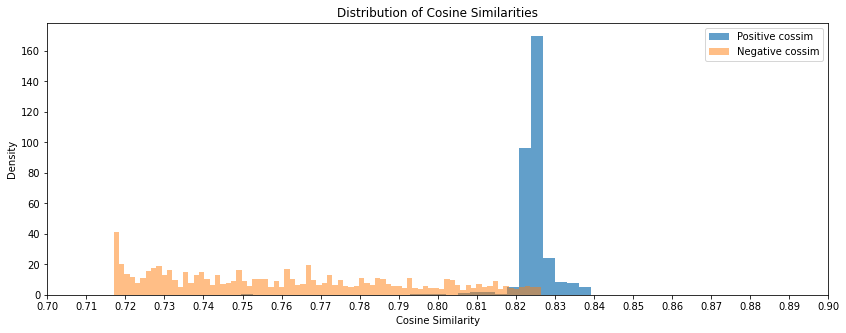

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(14, 5))

plt.hist(pos_cossims, bins=80, density=True, alpha=0.7, label="Positive cossim")
plt.hist(neg_cossims, bins=80, density=True, alpha=0.5, label="Negative cossim")

plt.xlim(0.7, 0.9)
plt.xticks(np.linspace(0.7, 0.9, 21))
plt.legend()
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.show()



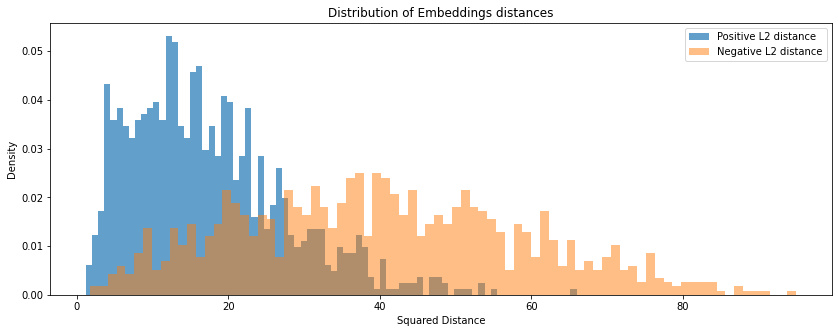

In [77]:
plt.figure(figsize=(14, 5))

plt.hist(d_p * d_p, bins=80, density=True, alpha=0.7, label="Positive L2 distance")
plt.hist(d_n * d_n, bins=80, density=True, alpha=0.5, label="Negative L2 distance")


plt.legend()
plt.title("Distribution of Embeddings distances")
plt.xlabel("Squared Distance")
plt.ylabel("Density")
plt.show()


In [96]:

#treshold of cossine sim

t = 0.819

total_accuracy = (np.sum(pos_cossims >= t) + np.sum(neg_cossims < t)) / 2000


print(f"Accuracy with t_cossim = {t} equals {round(total_accuracy * 100, 5)}%")


Accuracy with t_cossim = 0.819 equals 96.8%
